# Iteratively block configurations

## Imports

In [1]:
import time
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
#from operator import xor
#from blocks import Blocks
from worm_simulation import WormSimulation
from bonds import Bonds
from specific_heat import SpecificHeat
from pca import PrincipalComponent
from iterated_blocking import *
from utils import *
#from count_bonds import *
from specific_heat import SpecificHeat
from count_bonds import *
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnchoredText
import matplotlib.offsetbox as offsetbox
#from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
#from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from scipy.signal import find_peaks_cwt

%autoreload 2
%matplotlib notebook
import matplotlib as mpl
label_size = 14
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

Tc =  2./np.log(1+np.sqrt(2))    # critical temperature

markers = ['s', 'H', 'd', 'v', 'p', 'P']
colors = ['#2A9Df8', '#FF920B', '#65e41d', '#be67ff', '#ff7e79', '#959595']
markeredgecolors = ['#0256a3', '#ed4c18',  '#00B000', '#6633cc',
                    '#ee2324','#1c2022']

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
def create_dir_if_nonexistent(path):
    if os.path.exists(path):
        print(f"Path: {path} already exists, skipping.")
    #if not os.path.exists(path):
    else:
        print(f"Creating path: {path}")
        os.makedirs(path)

## Define relevant directories

In [3]:
config_dir64 = '../data/configs/64_lattice/separated_data/'
iter_block_prefix = '../data/iterated_blocking/64_lattice/'
config_dir64_b32 = iter_block_prefix + 'blocked64_b32/configs/'
config_dir32_b16 = iter_block_prefix + 'blocked32_b16/configs/'
config_dir16_b8 = iter_block_prefix + 'blocked16_b8/configs/'
config_dir8_b4 = iter_block_prefix + 'blocked8_b4/configs/'
config_dir4_b2 = iter_block_prefix + 'blocked4_b2/configs/'

results_prefix = '../data/bond_stats/iterated_blocking/64_lattice/'
save_dir64_b32 = results_prefix + 'blocked_64_b32/results/'
save_dir32_b16 = results_prefix + 'blocked_32_b16/results/'
save_dir16_b8 = results_prefix + 'blocked_16_b8/results/'
save_dir8_b4 = results_prefix + 'blocked_8_b4/results/'
save_dir4_b2 = results_prefix + 'blocked_4_b2/results/'

In [4]:
config_dirs64 = [config_dir64_b32, config_dir32_b16, config_dir16_b8,
                 config_dir8_b4, config_dir4_b2]
results_dirs64 = [save_dir64_b32, save_dir32_b16, save_dir16_b8, 
                  save_dir8_b4, save_dir4_b2]
for _dir in zip(config_dirs64, results_dirs64):
    create_dir_if_nonexistent(_dir[0])
    create_dir_if_nonexistent(_dir[1])

Path: ../data/iterated_blocking/64_lattice/blocked64_b32/configs/ already exists, skipping.
Path: ../data/bond_stats/iterated_blocking/64_lattice/blocked_64_b32/results/ already exists, skipping.
Path: ../data/iterated_blocking/64_lattice/blocked32_b16/configs/ already exists, skipping.
Path: ../data/bond_stats/iterated_blocking/64_lattice/blocked_32_b16/results/ already exists, skipping.
Path: ../data/iterated_blocking/64_lattice/blocked16_b8/configs/ already exists, skipping.
Path: ../data/bond_stats/iterated_blocking/64_lattice/blocked_16_b8/results/ already exists, skipping.
Path: ../data/iterated_blocking/64_lattice/blocked8_b4/configs/ already exists, skipping.
Path: ../data/bond_stats/iterated_blocking/64_lattice/blocked_8_b4/results/ already exists, skipping.
Path: ../data/iterated_blocking/64_lattice/blocked4_b2/configs/ already exists, skipping.
Path: ../data/bond_stats/iterated_blocking/64_lattice/blocked_4_b2/results/ already exists, skipping.


## Load $N_b$ results from previous calculation

In [5]:
# unblocked, original <Nb> data on L = 64 lattice
count_bonds64 = CountBonds(L=64, load=True)

Reading from: ../data/bond_stats/64_lattice/bond_stats_64.txt


In [6]:
count_bonds64_b32 = CountBonds(L=32, load=True,
                               data_file=save_dir64_b32 + 'bond_stats_32.txt')
count_bonds32_b16 = CountBonds(L=16, load=True,
                               data_file=save_dir32_b16 + 'bond_stats_16.txt')
count_bonds16_b8 = CountBonds(L=8, load=True,
                              data_file=save_dir16_b8 + 'bond_stats_8.txt')
count_bonds8_b4 = CountBonds(L=4, load=True,
                             data_file=save_dir8_b4 + 'bond_stats_4.txt')
count_bonds4_b2 = CountBonds(L=2, load=True,
                             data_file=save_dir4_b2 + 'bond_stats_2.txt')

Reading from: ../data/bond_stats/iterated_blocking/64_lattice/blocked_64_b32/results/bond_stats_32.txt
Reading from: ../data/bond_stats/iterated_blocking/64_lattice/blocked_32_b16/results/bond_stats_16.txt
Reading from: ../data/bond_stats/iterated_blocking/64_lattice/blocked_16_b8/results/bond_stats_8.txt
Reading from: ../data/bond_stats/iterated_blocking/64_lattice/blocked_8_b4/results/bond_stats_4.txt
Reading from: ../data/bond_stats/iterated_blocking/64_lattice/blocked_4_b2/results/bond_stats_2.txt


## Iteratively Block L = 64 configs

In [ ]:
configs64 = sorted([
    config_dir64 + i for i in os.listdir(config_dir64) if i.endswith('.txt')
])
# block L = 64 configs to L = 32 (first blocking step)
for file in configs64:
    t0 = time.time()
    block_configs(file, out_dir=config_dir64_b32)
    t1 = time.time()
    minutes, seconds = divmod(t1-t0, 60)
    print(f"\nTime to complete: {minutes} minutes, {seconds} seconds.\n")

In [ ]:
configs64_b32 = sorted([config_dir64_b32 + i 
                        for  i in os.listdir(config_dir64_b32)
                        if i.endswith('.txt')])

# block L = 32 configs to L = 16 (second blocking step)
t00 = time.time()
for file in configs64_b32:
    t0 = time.time()
    block_configs(file, out_dir=config_dir32_b16)
    t1 = time.time()
    minutes, seconds = divmod(t1-t0, 60)
    print(f"\nTime to complete: {minutes} minutes, {seconds} seconds.\n")
t2 = time.time()
mins1, secs1 = divmod(t2 - t0, 60)
print(f"\n\nTime to block all configurations: {mins1} minutes, {secs1} seconds.\n")

In [ ]:
configs32_b16 = sorted([config_dir32_b16 + i 
                        for i in os.listdir(config_dir32_b16) 
                        if i.endswith('.txt')])
t00 = time.time()
for file in configs32_b16:
    t0 = time.time()
    block_configs(file, out_dir=config_dir16_b8)
    t1 = time.time()
    mins, secs = divmod(t1-t0, 60)
    print(f"\nTime to complete: {mins} minutes, {secs} seconds.\n")
t2 = time.time()
mins1, secs1 = divmod(t2 - t00, 60)
print(f"\n\nTime to block all configurations: {mins1} minutes, {secs1} seconds.\n")

In [ ]:
configs16_b8 = sorted([config_dir16_b8 + i 
                        for i in os.listdir(config_dir16_b8) 
                        if i.endswith('.txt')])
for file in configs16_b8:
    t0 = time.time()
    block_configs(file, out_dir=config_dir8_b4)
    t1 = time.time()
    mins, secs = divmod(t1-t0, 60)
    print(f"\nTime to complete: {mins} minutes, {secs} seconds.\n")
t2 = time.time()
mins1, secs1 = divmod(t2 - t00, 60)
print(f"\n\nTime to block all configurations: {mins1} minutes, {secs1} seconds.\n")

In [ ]:
configs8_b4 = sorted([config_dir8_b4 + i 
                        for i in os.listdir(config_dir8_b4) 
                        if i.endswith('.txt')])
t00 = time.time()
for file in configs8_b4:
    t0 = time.time()
    block_configs(file, out_dir=config_dir4_b2)
    t1 = time.time()
    mins, secs = divmod(t1-t0, 60)
    print(f"\nTime to complete: {mins} minutes, {secs} seconds.\n")
t2 = time.time()
mins1, secs1 = divmod(t2 - t00, 60)
print(f"\n\nTime to block all configurations: {mins1} minutes, {secs1} seconds.\n")

In [ ]:
config_dir4_b2 = '../data/iterated_blocking/4_lattice/blocked_2/'
configs4_b2 = sorted([
    config_dir4_b2 + i for i in os.listdir(config_dir4_b2) if
    i.endswith('.txt')
])
for file in configs4_b2:
    block_configs(file)

## Run CountBonds on blocked configs

In [ ]:
# using L = 32 data after first blocking step (i.e. 64 --> 32)
count_bonds64_b32 = CountBonds(32, verbose=True, num_blocks=5,
                               data_dir=config_dir64_b32,
                               save_dir=save_dir64_b32)

In [ ]:
# using L = 16 data after second blocking step (i.e. 32 --> 16)
count_bonds32_b16 = CountBonds(16, verbose=True, num_blocks=5,
                               data_dir=config_dir32_b16,
                               save_dir=save_dir32_b16)

In [ ]:
# using L = 8 data after second blocking step (i.e. 16 --> 8)
count_bonds16_b8 = CountBonds(8, verbose=True, num_blocks=5,
                              data_dir=config_dir16_b8,
                              save_dir=save_dir16_b8)

In [ ]:
# using L = 4 data after second blocking step (i.e. 8 --> 4)
count_bonds8_b4 = CountBonds(4, verbose=True, num_blocks=5,
                              data_dir=config_dir8_b4,
                              save_dir=save_dir8_b4)

In [ ]:
# using L = 2 data after second blocking step (i.e. 4 --> 2)
count_bonds4_b2 = CountBonds(2, verbose=True, num_blocks=5,
                              data_dir=config_dir4_b2,
                              save_dir=save_dir4_b2)

In [ ]:
count_bonds2 = CountBonds(2, verbose=True, num_blocks=5,
                           data_dir=config_dir4_b2, save_dir=save_dir2)
# 21.4s, num_blocks=2

## Format data for plotting

In [7]:
Nb64 = np.array([
    (i[0], i[1]) for i in list(count_bonds64.bond_stats.values())
])
delta_Nb64 = np.array([
    (i[2], i[3]) for i in list(count_bonds64.bond_stats.values())
])
Nb64_temps = np.array([
    float(i) for i in list(count_bonds64.bond_stats.keys())
])

Nb32 = np.array([
    (i[0], i[1]) for i in list(count_bonds64_b32.bond_stats.values())
])
delta_Nb32 = np.array([
    (i[2], i[3]) for i in list(count_bonds64_b32.bond_stats.values())
])
Nb32_temps = np.array([
    float(i) for i in list(count_bonds64_b32.bond_stats.keys())
])

Nb16 = np.array([
    (i[0], i[1]) for i in list(count_bonds32_b16.bond_stats.values())
])
delta_Nb16 = np.array([
    (i[2], i[3]) for i in list(count_bonds32_b16.bond_stats.values())
])
Nb16_temps = np.array([
    float(i) for i in list(count_bonds32_b16.bond_stats.keys())
])

Nb8 = np.array([
    (i[0], i[1]) for i in list(count_bonds16_b8.bond_stats.values())
])
delta_Nb8 = np.array([
    (i[2], i[3]) for i in list(count_bonds16_b8.bond_stats.values())
])
Nb8_temps = np.array([
    float(i) for i in list(count_bonds16_b8.bond_stats.keys())
])

Nb4 = np.array([
    (i[0], i[1]) for i in list(count_bonds8_b4.bond_stats.values())
])
delta_Nb4 = np.array([
    (i[2], i[3]) for i in list(count_bonds8_b4.bond_stats.values())
])
Nb4_temps = np.array([
    float(i) for i in list(count_bonds8_b4.bond_stats.keys())
])

Nb2 = np.array([
    (i[0], i[1]) for i in list(count_bonds4_b2.bond_stats.values())
])
delta_Nb2 = np.array([
    (i[2], i[3]) for i in list(count_bonds4_b2.bond_stats.values())
])
Nb2_temps = np.array([
    float(i) for i in list(count_bonds4_b2.bond_stats.keys())
])

## Import Yannicks TRG data

In [ ]:
trg_temps = pd.read_csv('../data/TRG_blocking_data/temps.txt', engine='c',
                        delim_whitespace=True, header=None).values
trg_vals = pd.read_csv('../data/TRG_blocking_data/values.txt', engine='c',
                       delim_whitespace=True, header=None).values

In [ ]:
trg_temps.shape, trg_vals.shape

## Load Judah's TRG results for $T_{1111}$ using $1 + 1 = 0$ iterated blocking

In [8]:
T_data_file = '../data/TRG_blocking_data/T1111_64/nb-vol-blocked_x64.txt'
T_data = pd.read_csv(T_data_file, engine='c', 
                     delim_whitespace=True, header=None).values

In [9]:
T_data.shape

(26, 7)

In [10]:
T_temps = T_data[:, 0]
T_64 = T_data[:, 1]
T_32 = T_data[:, 2]
T_16 = T_data[:, 3]
T_8 = T_data[:, 4]
T_4 = T_data[:, 5]
T_2 = T_data[:, 6]

In [12]:
idxs0 = np.arange(15).tolist()
idxs1 = np.array([19, 24]).tolist()
idxs2 = np.arange(29, len(Nb64_temps)).tolist()

idxs_ = idxs0 + idxs1 + idxs2

In [14]:
Nb64_ = Nb64[idxs_]
Nb32_ = Nb32[idxs_]
Nb16_ = Nb16[idxs_]
Nb8_ = Nb8[idxs_]
Nb4_ = Nb4[idxs_]

<IPython.core.display.Javascript object>


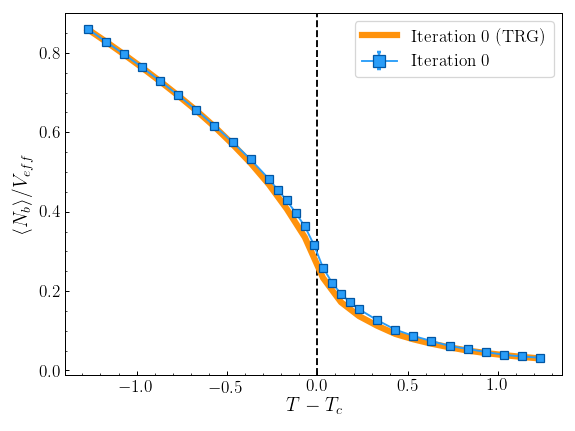

<Container object of 3 artists>

Text(0.5,0,'$T - T_c$')

Text(0,0.5,'$\\langle N_b\\rangle / V_{eff}$')

In [15]:
scale_arr = np.array([64*64, 32*32, 16*16, 8*8, 4*4])
fig, ax = plt.subplots()
#
ax.axvline(x=0, linestyle='--', color='k')

ax.plot(T_temps - Tc, T_64, #marker=markers[1], fillstyle='none',
        ls='-', linewidth=5., 
        color=colors[1], markeredgecolor=markeredgecolors[1],
        label='Iteration 0 (TRG)')
ax.errorbar(Nb64_temps[idxs_]- Tc, Nb64_[:,0]/scale_arr[0], yerr=Nb64_[:,1]/scale_arr[0],
            marker=markers[0], fillstyle='full',
            color=colors[0], markeredgecolor=markeredgecolors[0], 
            capsize=2., capthick=2., elinewidth=2.,
            label='Iteration 0')
leg = ax.legend(loc='best', markerscale=1.5, fontsize=14)
ax.set_xlabel(r"$T - T_c$", fontsize=16)
ax.set_ylabel(r"$\langle N_b\rangle / V_{eff}$", fontsize=16)
fig.tight_layout()

TRG_plot_dir = '../plots/TRG_blocking/'
TRG_plot_num = get_plot_num(TRG_plot_dir)
TRG_plot_file = TRG_plot_dir + f'Nb_avg_TRG_64_{TRG_plot_num}.png'
fig.savefig(TRG_plot_file, 
            dpi=400, bbox_inches='tight')

plt.show()

## Plot $\langle N_b\rangle$ vs. $T$

### Starting with L = 64

In [8]:
from utils import *

<IPython.core.display.Javascript object>


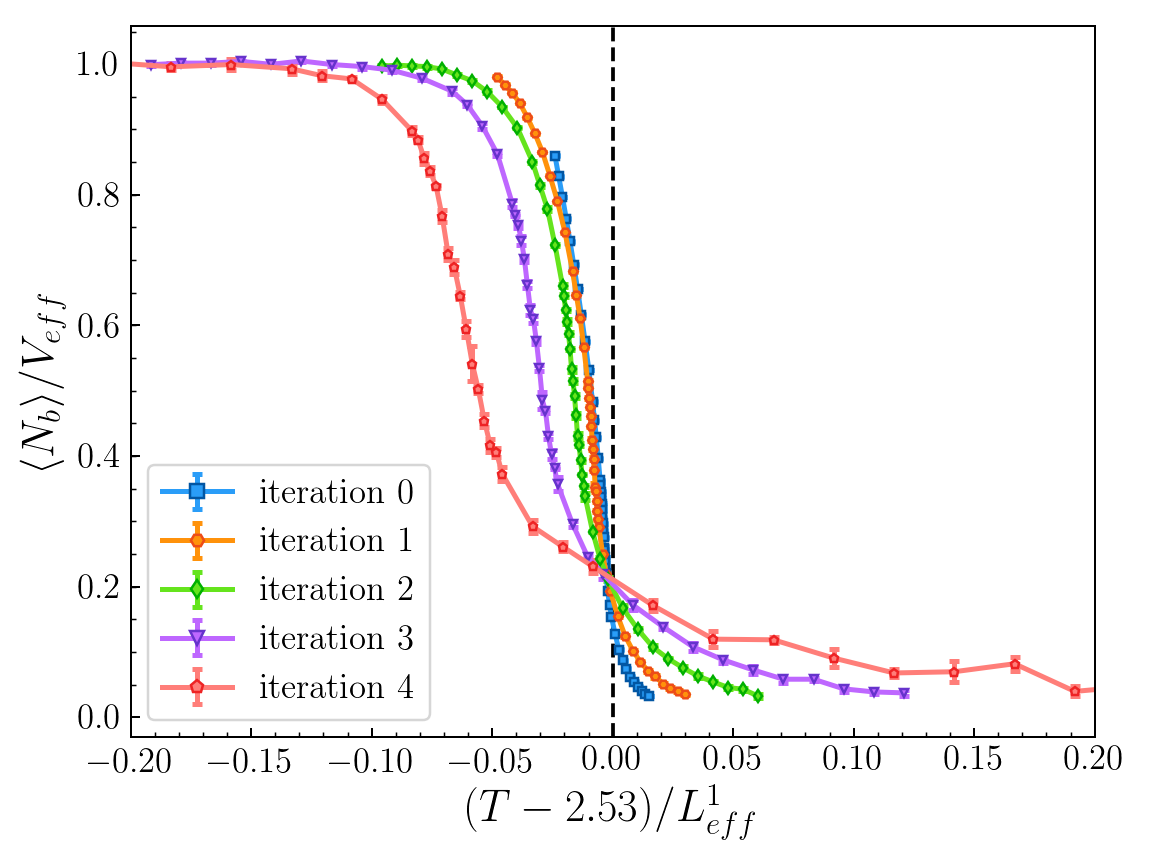

Saving file to: ../plots/iterated_blocking/64_data/Nb_fine_tuning/L_scale_factor_1/Nb_avg_2.53_1_25.png


Text(0.5,149.219,'$(T - 2.53)$$/ L_{eff}^{1}$')

Text(131.755,0.5,'$\\langle N_b\\rangle / V_{eff}$')

In [37]:
#markers = ['s', 'H', 'd', 'v', 'p', 'P']
#colors = ['#2A9Df8', '#FF920B', '#65e41d', '#be67ff', '#ff7e79', '#959595']
#markeredgecolors = ['#0256a3', '#ed4c18',  '#00B000', '#6633cc',
#                    '#ee2324','#1c2022']
#ff7e79

L_scale_factor = 1
#Tc_eff_arr = np.arange(2.26, 2.46, 0.01)
#for Tc_eff in Tc_eff_arr:
Tc_eff = 2.533
Nb_temps = np.array([Nb64_temps, Nb32_temps, Nb16_temps,
                     Nb8_temps, Nb4_temps]) - Tc_eff#, Nb2_temps]) - Tc_eff
L_arr = np.array([64, 32, 16, 8, 4, 2])
for idx, val in enumerate(Nb_temps):
    val /= L_arr[idx]**(L_scale_factor)
Nb_temps = Nb_temps#[::-1]
Nb_vals = np.array([Nb64[:,0]/(64*64), Nb32[:,0]/(32*32), 
                    Nb16[:,0]/(16*16), Nb8[:,0]/(8*8),
                    Nb4[:,0]/(4*4)])#, Nb2[:,0]/(2*2)])#[::-1]
Nb_errs = np.array([Nb64[:,1]/(64*64), Nb32[:,1]/(32*32), 
                    Nb16[:,1]/(16*16), Nb8[:,1]/(8*8),
                    Nb4[:,1]/(4*4)])#, Nb2[:,1]/(2*2)])#[::-1]
str_scale_factor = str(L_scale_factor)
Nb_xlabel = r"$(T - {:04.2f})$".format(Tc_eff) + r"$/ L_{eff}^{1}$" # update when changing!
Nb_ylabel = r"$\langle N_b\rangle / V_{eff}$"
Nb_values = {'x': Nb_temps, 'y': Nb_vals, 'y_err': Nb_errs}
Nb_labels = {'fig_labels': ["iteration 0", "iteration 1", "iteration 2",
                            "iteration 3", "iteration 4"],#, "iteration 5"],#[::-1],
                         #[r"$L = 64$", r"$L = 32$", r"$L = 16$", 
                         #   r"$L = 8$", r"$L = 4$", r"$L = 2$"][::-1],
             'x_label': Nb_xlabel, 'y_label': Nb_ylabel}
limits = {'x_lim': (-0.2, 0.2)}
Nb_plot_dir = f'../plots/iterated_blocking/64_data/Nb_fine_tuning/L_scale_factor_{L_scale_factor}/'
Nb_plot_num = get_plot_num(Nb_plot_dir)
Nb_out_file = Nb_plot_dir + f'Nb_avg_{Tc_eff:04.2f}_{L_scale_factor}_{Nb_plot_num}.png'
Nb_fig, Nb_ax = errorbar_plot(Nb_values, Nb_labels, Nb_out_file, 
                              limits, markersize=3.5, legend_loc='lower left',
                              Tc_line=0, reverse_colors=False)
Nb_ax.set_xlabel(Nb_xlabel, fontsize=18)
Nb_ax.set_ylabel(Nb_ylabel, fontsize=18)
#plt.savefig(Nb_out_file, dpi=400, bbox_inches='tight')

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
#ax2 = plt.axes([-0.1,0.48,0,0.52])
ax2 = plt.axes([0, 0, 1, 1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(Nb_ax, [0.51,0.41,0.46,0.56])
ax2.set_axes_locator(ip)
#mark_inset(Nb_ax, ax2, loc1.05, loc2=4, fc="none", ec='0.5')
# The data: only display for low temperature in the inset figure.
T_max = 0.02
ax2.axvline(x=0, linestyle='--', color='k')
ax2.errorbar(Nb_temps[5][Nb_temps[5]<=T_max], Nb_vals[5][Nb_temps[5]<=T_max], 
             yerr=Nb_errs[5][Nb_temps[5]<=T_max], 
             label=Nb_labels['fig_labels'][5], marker=markers[5], markersize=3.5, 
             fillstyle='full', color=colors[5], markeredgecolor=markeredgecolors[5], 
             ls='-', lw=2., elinewidth=2., capsize=2., capthick=2.)#, alpha=1.)
ax2.errorbar(Nb_temps[4][Nb_temps[4]<=T_max], Nb_vals[4][Nb_temps[4]<=T_max], 
             yerr=Nb_errs[4][Nb_temps[4]<=T_max], 
             label=Nb_labels['fig_labels'][4], marker=markers[4], markersize=3.5, 
             fillstyle='full', color=colors[4], markeredgecolor=markeredgecolors[4], 
             ls='-', lw=2., elinewidth=2., capsize=2., capthick=2.)#, alpha=0.9)
ax2.errorbar(Nb_temps[3][Nb_temps[3]<=T_max], Nb_vals[3][Nb_temps[3]<=T_max], 
             yerr=Nb_errs[3][Nb_temps[3]<=T_max], 
             label=Nb_labels['fig_labels'][3], marker=markers[3], markersize=3.5, 
             fillstyle='full', color=colors[3], markeredgecolor=markeredgecolors[3], 
             ls='-', lw=2., elinewidth=2., capsize=2., capthick=2.)#, alpha=0.8)
ax2.errorbar(Nb_temps[2][Nb_temps[2]<=T_max], Nb_vals[2][Nb_temps[2]<=T_max], 
             yerr=Nb_errs[2][Nb_temps[2]<=T_max], 
             label=Nb_labels['fig_labels'][2], marker=markers[2], markersize=3.5, 
             fillstyle='full', color=colors[2], markeredgecolor=markeredgecolors[2], 
             ls='-', lw=2., elinewidth=2., capsize=2., capthick=2.)#, alpha=0.6)
ax2.errorbar(Nb_temps[1][Nb_temps[1]<=T_max], Nb_vals[1][Nb_temps[1]<=T_max], 
             yerr=Nb_errs[1][Nb_temps[1]<=T_max], 
             label=Nb_labels['fig_labels'][1], marker=markers[1], markersize=3.5, 
             fillstyle='full', color=colors[1], markeredgecolor=markeredgecolors[1], 
             ls='-', lw=2., elinewidth=2., capsize=2., capthick=2.)#, alpha=0.6)
ax2.errorbar(Nb_temps[0][Nb_temps[0]<=T_max], Nb_vals[0][Nb_temps[0]<=T_max], 
             yerr=Nb_errs[0][Nb_temps[0]<=T_max], 
             label=Nb_labels['fig_labels'][0], marker=markers[0], markersize=3.5, 
             fillstyle='full', color=colors[0], markeredgecolor=markeredgecolors[0], 
             ls='-', lw=2., elinewidth=2., capsize=2., capthick=2.)#, alpha=0.6)
#ax2.legend(loc=0)
ax2.set_xlim(-0.05, 0.0001)
ax2.set_ylim(0.05, 1.04)
# Some ad hoc tweaks.
#Nb_ax.set_ylim(-0.1,0.52)
ax2.set_xticks(np.array([-0.05, -0.025, 0.]))
ax2.set_yticks(np.array([0.2, 0.4, 0.6, 0.8, 1.0]))
ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor='w', fontsize=11)
ax2.set_yticklabels(ax2.get_yticks(), backgroundcolor='w', fontsize=11)
ax2.tick_params(axis='x', which='major', pad=8)

plt.show()
#Nb_fig.tight_layout()
plt.savefig(Nb_out_file, dpi=400, bbox_inches='tight')

<IPython.core.display.Javascript object>


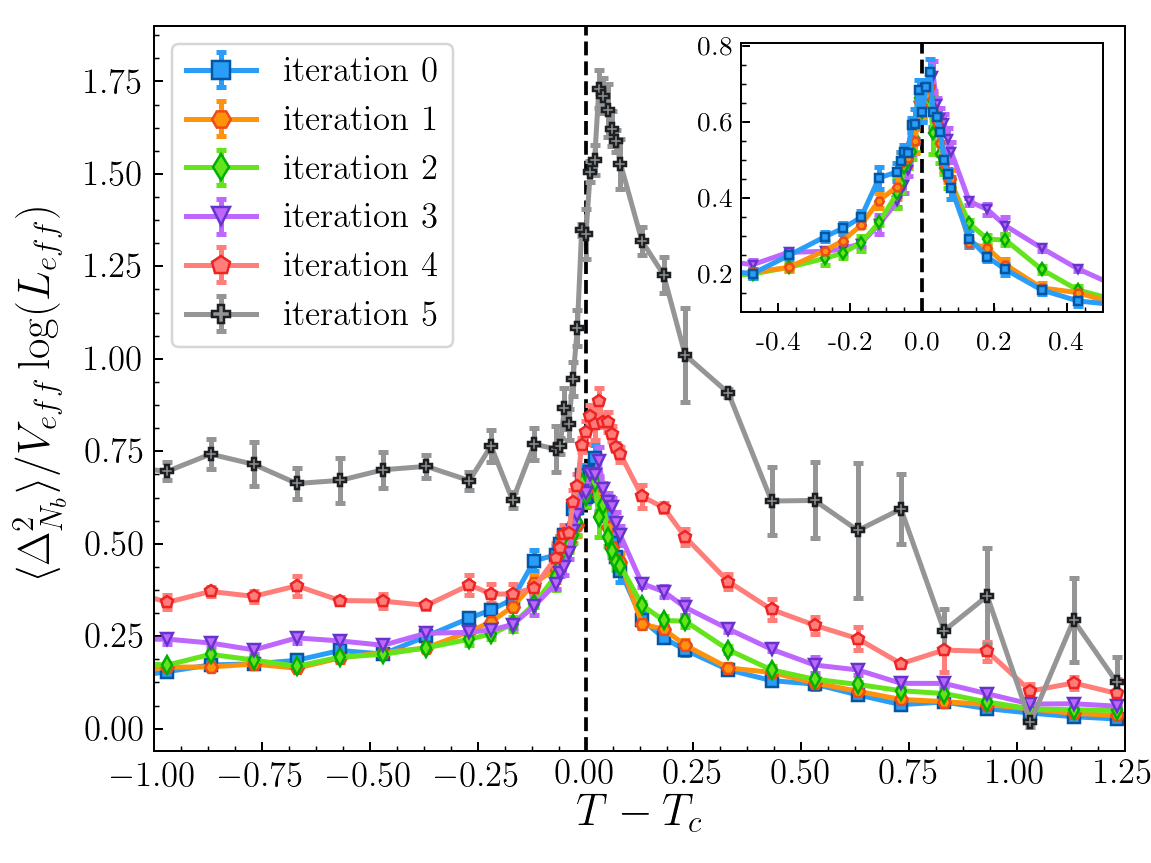

Saving file to: ../plots/iterated_blocking/64_data/delta_Nb_all_247.png


Text(0.5,118.717,'$T - T_c \\quad $')

Text(145.874,0.5,'$\\langle \\Delta_{N_b}^2\\rangle / V_{eff} \\log(L_{eff})$')

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

(-0.5, 0.5)

(0.1, 0.81)

[Text(0,0,'-0.4'),
 Text(0,0,'-0.2'),
 Text(0,0,'0.0'),
 Text(0,0,'0.2'),
 Text(0,0,'0.4')]

[Text(0,0,'0.2'), Text(0,0,'0.4'), Text(0,0,'0.6'), Text(0,0,'0.8')]

In [26]:
#delta_Nb_temps = np.array([Nb64_temps, 
delta_Nb_temps = np.array([Nb64_temps,
                           Nb32_temps, 
                           Nb16_temps, 
                           Nb8_temps,
                           Nb4_temps,
                           Nb2_temps]) - Tc
delta_Nb_scale_arr = np.array([64*64*np.log(64),
                               32*32*np.log(32),
                               16*16*np.log(16),
                               8*8*np.log(8),
                               4*4*np.log(4),
                               2*2*np.log(2)])
delta_Nb_vals = np.array([delta_Nb64[:,0] / delta_Nb_scale_arr[0], 
                          delta_Nb32[:,0] / delta_Nb_scale_arr[1], 
                          delta_Nb16[:,0] / delta_Nb_scale_arr[2],
                          delta_Nb8[:,0] / delta_Nb_scale_arr[3],
                          delta_Nb4[:,0] / delta_Nb_scale_arr[4],
                          delta_Nb2[:,0] / delta_Nb_scale_arr[5]])
delta_Nb_err = np.array([delta_Nb64[:,1] / delta_Nb_scale_arr[0],
                         delta_Nb32[:,1] / delta_Nb_scale_arr[1],
                         delta_Nb16[:,1] / delta_Nb_scale_arr[2],
                         delta_Nb8[:,1] / delta_Nb_scale_arr[3],
                         delta_Nb4[:,1] / delta_Nb_scale_arr[4],
                         delta_Nb2[:,1] / delta_Nb_scale_arr[5]])
delta_Nb_values = {'x': delta_Nb_temps, 'y': delta_Nb_vals,
                   'y_err': delta_Nb_err}
delta_Nb_xlabel = r"$T - T_c \quad $"
delta_Nb_ylabel = r"$\langle \Delta_{N_b}^2\rangle / V_{eff} \log(L_{eff})$"
#delta_Nb_labels = {'fig_labels': [r"$L = 64$", 
#                                  r"$L = 32$", 
#                                  r"$L = 16$", 
#                                  r"$L = 8$",
#                                  r"$L = 4$"],
                                  #r"$L = 2$"],
delta_Nb_labels = {'fig_labels': ["iteration 0", "iteration 1", "iteration 2",
                                  "iteration 3", "iteration 4", "iteration 5"],#[::-1],
                   'x_label': delta_Nb_xlabel, 'y_label': delta_Nb_ylabel}
delta_Nb_limits = {'x_lim': (-1., 1.25), 'y_lim': (-0.06, 1.9)}
delta_Nb_plot_dir = '../plots/iterated_blocking/64_data/'
delta_Nb_plot_num = get_plot_num(delta_Nb_plot_dir)
delta_Nb_out_file = (delta_Nb_plot_dir 
                     + 'delta_Nb_all_{}.png'.format(delta_Nb_plot_num))
delta_Nb_fig, delta_Nb_ax = errorbar_plot(delta_Nb_values, 
                                          delta_Nb_labels, delta_Nb_out_file, 
                                          delta_Nb_limits, Tc_line=0, 
                                          legend_loc='upper left',
                                          #num_graphs=5
                                          markersize=5, reverse_colors=False)
delta_Nb_ax.set_xlabel(delta_Nb_xlabel, fontsize=18)
delta_Nb_ax.set_ylabel(delta_Nb_ylabel, fontsize=18)

#Nb_fig, Nb_ax = errorbar_plot(Nb_values, Nb_labels, Nb_out_file, 
#                              limits, markersize=3.5, legend_loc='lower left',
#                              Tc_line=0, reverse_colors=False)
# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
#ax2 = plt.axes([-0.1,0.48,0,0.52])
ax2 = plt.axes([0, 0, 1, 1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(delta_Nb_ax, [0.605,0.605,0.372,0.372])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
#mark_inset(Nb_ax, ax2, loc1.05, loc2=4, fc="none", ec='0.5')

# The data: only display for low temperature in the inset figure.
T_min = -0.3
T_max = 0.3
ax2.axvline(x=0, linestyle='--', color='k')
#import numpy.ma as ma
#mask5 = ma.masked_inside(delta_Nb_temps[5], -0.10, 0.10)
#mask4 = ma.masked_inside(delta_Nb_temps[4], -0.10, 0.10)
mask3 = ma.masked_inside(delta_Nb_temps[3], -0.60, 0.60)
mask2 = ma.masked_inside(delta_Nb_temps[2], -0.60, 0.60)
mask1 = ma.masked_inside(delta_Nb_temps[1], -0.60, 0.60)
mask0 = ma.masked_inside(delta_Nb_temps[0], -0.60, 0.60)
ax2.errorbar(delta_Nb_temps[3][mask3.mask], 
             delta_Nb_vals[3][mask3.mask], 
             yerr=delta_Nb_err[3][mask3.mask], 
             label=delta_Nb_labels['fig_labels'][3], marker=markers[3], markersize=3.5, 
             fillstyle='full', color=colors[3], markeredgecolor=markeredgecolors[3], 
             ls='-', lw=2., elinewidth=2., capsize=2., capthick=2.)#, alpha=1.)
ax2.errorbar(delta_Nb_temps[2][mask2.mask], 
             delta_Nb_vals[2][mask2.mask], 
             yerr=delta_Nb_err[2][mask2.mask], 
             label=delta_Nb_labels['fig_labels'][2], marker=markers[2], markersize=3.5, 
             fillstyle='full', color=colors[2], markeredgecolor=markeredgecolors[2], 
             ls='-', lw=2., elinewidth=2., capsize=2., capthick=2.)#, alpha=0.9)
ax2.errorbar(delta_Nb_temps[1][mask1.mask], 
             delta_Nb_vals[1][mask1.mask], 
             yerr=delta_Nb_err[1][mask1.mask], 
             label=delta_Nb_labels['fig_labels'][1], marker=markers[1], markersize=3.5, 
             fillstyle='full', color=colors[1], markeredgecolor=markeredgecolors[1], 
             ls='-', lw=2., elinewidth=2., capsize=2., capthick=2.)#, alpha=0.8)
ax2.errorbar(delta_Nb_temps[0][mask0.mask], 
             delta_Nb_vals[0][mask0.mask], 
             yerr=delta_Nb_err[0][mask0.mask], 
             label=delta_Nb_labels['fig_labels'][0], marker=markers[0], markersize=3.5, 
             fillstyle='full', color=colors[0], markeredgecolor=markeredgecolors[0], 
             ls='-', lw=2., elinewidth=2., capsize=2., capthick=2.)#, alpha=0.6)
#ax2.legend(loc=0)
#ax2.set_xlim(-0.05, 0.001)
ax2.set_xlim(-0.5, 0.5)
ax2.set_ylim(0.1, 0.81)
# Some ad hoc tweaks.
#Nb_ax.set_ylim(-0.1,0.52)
ax2.set_xticks(np.array([-0.4, -0.2, 0, 0.2, 0.4]))
ax2.set_yticks(np.array([0.2, 0.4, 0.6, 0.8]))
ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor='w', fontsize=11)
ax2.set_yticklabels(ax2.get_yticks(), backgroundcolor='w', fontsize=11)
ax2.tick_params(axis='x', which='major', pad=8)
plt.show()
#Nb_fig.tight_layout()
plt.savefig(delta_Nb_out_file, dpi=400, bbox_inches='tight')

In [ ]:
import numpy.ma as ma
x = ma.masked_inside(delta_Nb_temps[4], -0.15, 0.15)
#delta_Nb_vals[4][[delta_Nb_vals[4][T_min <= delta_Nb_vals[4]]]][delta_Nb_vals[4] <= T_max]
#lb4 = delta_Nb_vals[4][T_min <= delta_Nb_temps[4]]
#delta_Nb_temps[4][x]
print(delta_Nb_temps[4][x.mask])
#sorted(delta_Nb_vals[4][T_min <= delta_Nb_temps[4]][delta_Nb_temps[4] <= T_max])

###  Starting with L = 32

In [ ]:
def get_demo_image():
    from matplotlib.cbook import get_sample_data
    import numpy as np
    f = get_sample_data("axes_grid/bivariate_normal.npy", asfileobj=False)
    z = np.load(f)
    # z is a numpy array of 15x15
    return z, (-3, 4, -4, 3)

fig, ax = plt.subplots(figsize=[5, 4])

# prepare the demo image
Z, extent = get_demo_image()
Z2 = np.zeros([150, 150], dtype="d")
ny, nx = Z.shape
Z2[30:30 + ny, 30:30 + nx] = Z

# extent = [-3, 4, -4, 3]
ax.imshow(Z2, extent=extent, interpolation="nearest",
          origin="lower")

plt.draw()
plt.show()

In [ ]:
def plot_with_colors(data_dict, **kwargs):
    plot_dict = {}
    for key, val in data_dict.items():
        variable, L = key.split('_')
        plot_dict[L] = val
    #x_label = args['x_label']
    #y_label = args['y_label']
    #shift_T = args['shift_T']
    #scale_factor = args['scale_factor']
    #out_dir = args['out_dir']
    #out_file = args['out_file']
    #x_lim = args['x_lim']
    #y_lim = args['y_lim']
    #except KeyError as e:
    #    print(f"{e} is not a valid key in **kwargs", continuing)
    #    continue
    if kwargs['shift_T']:
        for key, val in plot_dict.items():
            val[:, 0] -= Tc
    
#    ax.errorbar((-Tc0)*16**(scale_factor),
#                Nb16[:,0]/(2*16*16), 
#                yerr=Nb16[:,1]/(2*16*16),
    fig, ax = plt.subplots()
    try:
        ax.errorbar(plot_dict['16'][:, 0], plot_dict['16'][:, 1],
                    yerr=plot_dict['16'][:, 2],
                    marker='s', markersize=5., 
                    color='C0', markeredgecolor='#1f1b93',
                    lw=2, alpha=1., ls='-', fillstyle='full',
                    elinewidth=2., capsize=2, capthick=2,
                    label='L=16')
        #ax.errorbar((Nb8_temps-Tc0)*8**(scale_factor), 
        #            Nb8[:,0]/(2*8*8),
        #            yerr=Nb8[:,1]/(2*8*8),
        ax.errorbar(plot_dict['8'][:,0], plot_dict['8'][:, 1],
                    yerr=plot_dict['8'][:, 2],
                    color='C1', markeredgecolor='#ed4c18', 
                    marker='H', fillstyle='full',
                    markersize=5,  lw=2, alpha=1., ls='-', 
                    elinewidth=2., capsize=2, capthick=2,
                    label='L=8')
        #ax.errorbar((Nb4_temps-Tc0)*4**(scale_factor), 
        #            Nb4[:,0]/(2*4*4), 
        #            yerr=Nb4[:,1]/(2*4*4),
        ax.errorbar(plot_dict['4'][:, 0], plot_dict['4'][:, 1],
                    yerr=plot_dict['8'][:, 2],
                    marker='d', 
                    color='#65e41d', markeredgecolor='#00B000', 
                    fillstyle='full', markersize=5,  lw=2, 
                    alpha=1., ls='-',
                    elinewidth=2.,  capsize=2, capthick=2,
                    label='L=4')
        #ax.errorbar((Nb2_temps-Tc0)*2**(scale_factor),
        #            Nb2[:,0]/(2*2*2),
        #            yerr=Nb2[:,1]/(2*2*2),
        ax.errorbar(plot_dict['2'][:, 0], plot_dict['2'][:, 1],
                    yerr=plot_dict['8'][:, 2],
                    marker='v', fillstyle='full', markersize=5, lw=2,
                    color='#be67ff', markeredgecolor='#833c9f', 
                    #color='#fe6432', markeredgecolor='#EA2213',
                    alpha=1., ls='-',
                    elinewidth=2., capsize=2., capthick=2., label=r"$L = 2$")
    except KeyError as e:
        print(f"plot_dict has no key: {e}, continuing.")
    ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
    ax.set_xlim(-0.05,0.4)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    #ax.set_xlabel(r"$(T-T_c)L^{%.2g}$" % scale_factor, fontsize=16)
    #ax.set_ylabel(r"$\langle N_b\rangle/2V$", fontsize=16)
    #out_dir = '../plots/iterated_blocking/bond_stats/Nb_avg/'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    existing = [int(i.split('_')[-1].rstrip('.png')) for 
                i in os.listdir(out_dir)  if i.endswith('.png')]
    try:
        latest_num = max(existing)
    except ValueError:
        latest_num = 0
    new_num = latest_num + 1
    out_file = out_dir + 'Nb_all_{}.png'.format(new_num)
    print("Saving file to: {}".format(out_file))
    plt.savefig(out_file, dpi=600, bbox_inches='tight')
    plt.show()





In [ ]:
Nb_dict = {'Nb_32': [Nb32_temps, Nb32[:,0], Nb32[:,1]],
           'Nb_16': [Nb16_temps, Nb16[:,0], Nb16[:,1]],
           'Nb_8': [Nb8_temps, Nb8[:,0], Nb8[:,1]],
           'Nb_4': [Nb4_temps, Nb4[:,0], Nb4[:,1]]}
args {'scale_factor': scale_factor}

In [ ]:

ax1 = plt.subplot(311)
plt.plot(t, s1)
plt.setp(ax1.get_xticklabels(), fontsize=6)

# share x only
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t, s2)
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)

# share x and y
ax3 = plt.subplot(313, sharex=ax1, sharey=ax1)
plt.plot(t, s3)
plt.xlim(0.01, 5.0)
plt.show()

In [ ]:
%autoreload 2
from utils import *

In [ ]:
Nb_temps[0].shape, Nb_vals.shape, Nb_err.shape

In [ ]:
Nb_temps = np.array([(Nb16_temps - Tc0)*16**(scale_factor),
                     (Nb8_temps - Tc0)*8**(scale_factor),
                     (Nb4_temps - Tc0)*4**(scale_factor),
                     (Nb2_temps - Tc0)*2**(scale_factor)])
Nb_vals = np.array([Nb16[:,0]/(16*16), 
                    Nb8[:,0]/(8*8),
                    Nb4[:,0]/(4*4),
                    Nb2[:,0]/(2*2)])
Nb_err = np.array([Nb16[:,1]/(16*16), 
                   Nb8[:,1]/(8*8),
                   Nb4[:,1]/(4*4),
                   Nb2[:,1]/(2*2)])
Nb_values_dict = {'x': Nb_temps, 'y': Nb_vals, 'y_err': Nb_err}
fig_labels = np.array(["L = 16", "L = 8", "L = 4", "L = 2"])
x_label = r"$(T-T_c)L^{%.2g}$" % scale_factor
y_label = r"$\langle N_b\rangle/2V$"
labels = {'fig_labels': fig_labels, 'x_label': x_label, 'y_label': y_label}
limits = {'x_lim': (-1.25, 1.25)}
Nb_plot_dir = '../plots/iterated_blocking/bond_stats/Nb_avg/'
Nb_plot_num = get_plot_num(Nb_plot_dir)
Nb_plot_file = Nb_plot_dir + str(Nb_plot_num)
Nb_plot_num = get_plot_num('../plots/iterated_blocking/bond_stats/Nb_avg/')

errorbar_plot(Nb_values_dict, labels, Nb_plot_file, limits=limits)

In [ ]:
#with sns.axes_style("darkgrid"):
#fig, ax = plt.subplots()
scale_factor = 1.
#ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
Tc0 = Tc

#            label='L=32')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#ax1 = plt.subplot(211)
ax1p1 = ax1.plot(trg_temps, trg_vals[:,1], 
         color='C0', markeredgecolor='#1f1b93',
         marker='s', markersize=5, lw=2, ls='-', 
         label='L=16')
ax1p2 = ax1.plot(trg_temps, trg_vals[:,2], 
         color='C1', markeredgecolor='#ed4c18', 
         marker='H', markersize=5, lw=2, ls='-', 
         label='L=8')
ax1p3 = ax1.plot(trg_temps, trg_vals[:,3], 
         color='#65e41d', markeredgecolor='#00B000', 
        marker='d', markersize=5, lw=2, ls='-', 
        label='L=4')
ax1_p4 = ax1.plot(trg_temps, trg_vals[:,4], 
         color='#be67ff', markeredgecolor='#833c9f', 
         marker='v', markersize=5, lw=2, ls='-', 
         label='L=2')
#plt.setp(ax1.get_yticklabels())

#ax2 = plt.subplot(221, sharex=ax1)
ax2p1 = ax2.errorbar((Nb16_temps-Tc0)*16**(scale_factor),
            Nb16[:,0]/(16*16), 
            yerr=Nb16[:,1]/(16*16),
            marker='s', 
            color='C0', markeredgecolor='#1f1b93',
            markersize=5., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2., capsize=2, capthick=2,
            label='L=16')
ax2p2 = ax2.errorbar((Nb8_temps-Tc0)*8**(scale_factor), 
            Nb8[:,0]/(8*8),
            yerr=Nb8[:,1]/(8*8),
            color='C1', markeredgecolor='#ed4c18', 
            marker='H', fillstyle='full',
            markersize=5, 
            lw=2, alpha=1., ls='-',
            elinewidth=2., capsize=2, capthick=2,
            label='L=8')
ax2p3 = ax2.errorbar((Nb4_temps-Tc0)*4**(scale_factor), 
            Nb4[:,0]/(4*4), 
            yerr=Nb4[:,1]/(4*4),
            marker='d', 
            color='#65e41d', markeredgecolor='#00B000', 
            fillstyle='full', markersize=5,  lw=2, 
            alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=4')
ax2p4 = ax2.errorbar((Nb2_temps-Tc0)*2**(scale_factor),
            Nb2[:,0]/(2*2),
            yerr=Nb2[:,1]/(2*2),
            marker='v',
            fillstyle='full', markersize=5, lw=2,
            color='#be67ff', markeredgecolor='#833c9f', 
            #color='#fe6432', markeredgecolor='#EA2213',
            alpha=1., ls='-',
            elinewidth=2., capsize=2., capthick=2.,
            label=r"$L = 2$")
#plt.setp(ax1.get_yticklabels(), visible=False)

ax1_leg = ax1.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax1_xlim = ax1.set_xlim(-1.25, 1.25)
ax1_xlab = ax1.set_xlabel(r"$T-T_c$", fontsize=16)
ax1_ylab = ax1.set_ylabel(r"$T_{1111}$", fontsize=16)
ax2_leg = ax2.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax2_xlim = ax2.set_xlim(-1.25, 1.25)
#ax2_xlab = ax2.set_xlabel(r"$(T-T_c)L^{%.2g}$" % scale_factor, fontsize=16)
ax2_xlab = ax2.set_xlabel(r"$(T-T_c)L^{%.2g}$" % scale_factor, fontsize=16)
ax2_ylab = ax2.set_ylabel(r"$\langle N_b\rangle/V$", fontsize=16)
out_dir = '../plots/iterated_blocking/bond_stats/Nb_avg/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'Nb_all_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

## Plot  $\langle \Delta_{N_b}^2\rangle$ vs. $T$

In [ ]:
fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
#EE2324'
#Db1f0e'
ax.errorbar((Nb2_temps-Tc)*2, delta_Nb2[:,0]/(2*2*2*np.log(2)), 
            yerr=delta_Nb2[:,1]/(2*2*2*np.log(2)),
            fillstyle='full', markersize=5,  lw=2, 
            color='#EE2324', markeredgecolor='#8d0015',
            marker='v',  alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=2')
ax.errorbar((Nb4_temps-Tc)*4, delta_Nb4[:,0]/(2*4*4*np.log(4)), 
            yerr=delta_Nb4[:,1]/(2*4*4*np.log(4)),
            fillstyle='full', markersize=5,  lw=2, 
            color='#be67ff', markeredgecolor='#833c9f',
            marker='v',  alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=4')
ax.errorbar((Nb8_temps-Tc)*8, delta_Nb8[:,0]/(2*8*8*np.log(8)),
            yerr=delta_Nb8[:,1]/(2*8*8*np.log(8)),
            color='#65e41d', markeredgecolor='#00B000', 
            marker='d', fillstyle='full', 
            lw=2, alpha=1., ls='-', markersize=5, 
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=8')
ax.errorbar((Nb16_temps-Tc)*16, delta_Nb16[:,0]/(2*16*16*np.log(16)), 
            yerr=delta_Nb16[:,1]/(2*16*16*np.log(16)),
            marker='H', 
            color='C1', markeredgecolor='#ed4c18',
            markersize=5., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=16')
ax.errorbar((Nb32_temps-Tc)*32, delta_Nb32[:,0]/(2*32*32*np.log(32)), 
            yerr=delta_Nb32[:,1]/(2*32*32*np.log(32)),
            marker='s', color='C0', alpha=1.,
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2,
            elinewidth=2., capsize=2, capthick=2,
            label='L=32')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(-5,5)
ax.set_xlabel(r"$(T-T_c)L$", fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle/\log(L)$", fontsize=16)
out_dir = '../plots/iterated_blocking/bond_stats/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'delta_Nb_all_blocked_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar((Nb32_temps-Tc)*32**(-0.6043), 
            delta_Nb32[:,0]/(2*32*32*32**(0.329)), 
            yerr=delta_Nb32[:,1]/(2*32*32*32**(1./4)),
            marker='s', color='C0', alpha=1.,
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2,
            elinewidth=2., capsize=2, capthick=2,
            label='L=32')
ax.errorbar((Nb16_temps-Tc)*16**(-0.6043), 
            delta_Nb16[:,0]/(2*16*16*16**(0.329)), 
            yerr=delta_Nb16[:,1]/(2*16*16*16**(1./4)),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=16')
ax.errorbar((Nb8_temps-Tc)*8**(-0.6043), 
            delta_Nb8[:,0]/(2*8*8*8**(0.329)),
            yerr=delta_Nb8[:,1]/(2*8*8*8**(1./4)),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=2, alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=8')
ax.errorbar((Nb4_temps-Tc)*4**(-0.6043),
            delta_Nb4[:,0]/(2*4*4*4**(0.329)), 
            yerr=delta_Nb4[:,1]/(2*4*4*4**(1./4)),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=2, 
            alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(-0.05, 0.05)
ax.set_xlabel('$(T-T_c)L^{-0.6043}$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle/L^{0.329}$", fontsize=16)
out_dir = '../plots/iterated_blocking/bond_stats/collapsed/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'delta_Nb_all_collapsed_zoomed_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

## Peak analysis

## FWHM of $\langle \Delta_{N_b}^2\rangle/\log(L)$ vs $(T-T_c)L$

In [ ]:
from scipy.interpolate import UnivariateSpline
def fwhm1(x, y):
    # create a spline of x and blue-np.max(blue)/2 
    spline = UnivariateSpline(x, y-np.max(y)/2, s=0)
    roots = spline.roots()
    r1 = roots[0]
    r2 = roots[-1]
    #r1, r2 = spline.roots() # find the roots
    return np.abs(r1 - r2)

In [ ]:
fwhm32 = fwhm1((Nb32_temps-Tc)*32, delta_Nb32[:,0]/(2*32*32*np.log(32)))
fwhm16 = fwhm1((Nb16_temps-Tc)*16, delta_Nb16[:,0]/(2*16*16*np.log(16)))
fwhm8 = fwhm1((Nb8_temps-Tc)*8, delta_Nb8[:,0]/(2*8*8*np.log(8)))
fwhm4 = fwhm1((Nb4_temps-Tc)*4, delta_Nb4[:,0]/(2*4*4*np.log(4)))

fwhm32, fwhm16, fwhm8, fwhm4

In [ ]:
#x_fwhm = np.linspace(8, 32, 500)
L_fwhm = np.array([8, 16, 32])
fwhm_arr = np.array([fwhm8, fwhm16, fwhm32])
m_fwhm, b_fwhm = np.polyfit(L_fwhm, fwhm_arr, 1)
x_fwhm = np.linspace(4, 32, 500)
fwhm_fit = b_fwhm + x_fwhm * m_fwhm

m_fwhm, b_fwhm

In [ ]:
fig, ax = plt.subplots()
ax.plot(32, fwhm32,
          marker='s', 
          markeredgecolor='#1f1b93',
          markersize=8., 
          color='C0',
          ls='',
          label=r"$L = 32$")
ax.plot(16, fwhm16,
          marker='H', 
          color='#ABE479', 
          markeredgecolor='#00B000',
          markersize=8, 
          ls='',
          label=r"$L = 16$")
ax.plot(8, fwhm8,
          marker='d',
          markersize=8, 
          color='#be67ff',
          markeredgecolor='#833c9f', 
          ls='', 
          label=r"$L = 8$")
ax.plot(4, fwhm4,
          marker='v', 
          markersize=8,
          color='C1',
          markeredgecolor='#ed4c18',
          ls='',
          label=r"$L=4$")
ax.plot(x_fwhm, fwhm_fit,
        ls='-',
        color='k',
        label=r"${:.5g} + {:.3g}L$".format(b_fwhm, m_fwhm))
        #label=r"${:.4g}\,\,\exp({{{:.4g}L}})$".format(np.exp(b0), m0))
#ax.legend()
#ax.set_xlim(1./32-0.005, 1./4+0.05)
plt.legend(loc='best', fontsize=14, markerscale=1.6)
#plt.title(r"$\log\left(\max\{\langle \Delta_{N_b}^2\rangle\}\right)$ vs. $L$", 
#          fontsize=18)
ylabel = (r"FWHM of $\langle \Delta_{N_b}^2 \rangle / \log(L)$" + " vs. "
          + r"$(T-T_c)L$")

 
plt.ylabel(ylabel, 
           fontsize=16)
plt.xlabel(r"$L$", fontsize=16)
ax.grid()
out_dir = '../plots/peak_analysis/iterated_blocking/FWHM/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'fwhm_fit_blocked_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

### Peak Value

In [ ]:
delta_Nb32_peak = np.max(delta_Nb32[:,0]/(2*32*32))
delta_Nb16_peak = np.max(delta_Nb16[:,0]/(2*16*16))
delta_Nb8_peak = np.max(delta_Nb8[:,0]/(2*8*8))
delta_Nb4_peak = np.max(delta_Nb4[:,0]/(2*4*4))

In [ ]:
inv_L_arr = np.log(np.array([1./32, 1./16, 1./8, 1./4]))
delta_Nb_peak_arr = np.log(np.array([
    delta_Nb32_peak, delta_Nb16_peak, delta_Nb8_peak, delta_Nb4_peak
]))
m0, b0 = np.polyfit(inv_L_arr, delta_Nb_peak_arr, 1)

In [ ]:
fit_x0 = np.linspace(1./32, 1./4, 500)
#fit_x = np.arange(2, 32)
log_y0_fit = b0 + np.log(fit_x0) * m0
fit_y0 = np.exp(log_y0_fit)

In [ ]:
fig, ax = plt.subplots()
ax.loglog(1./32, delta_Nb32_peak,
          marker='s', 
          markeredgecolor='#1f1b93',
          #markersize=5., 
          color='C0',
          ls='',
          label=r"$L = 32$")
ax.loglog(1./16, delta_Nb16_peak,
          marker='H', 
          color='C1',
          markeredgecolor='#ed4c18',
          #markersize=5, 
          ls='',
          label=r"$L = 16$")
ax.loglog(1./8, delta_Nb8_peak,
          marker='v',
          #markersize=5, 
          color='#ABE479', 
          markeredgecolor='#00B000',
          ls='', 
          label=r"$L = 8$")
ax.loglog(1./4, delta_Nb4_peak,
          marker='d', 
          color='#be67ff',
          markeredgecolor='#833c9f', 
          #markersize=5, 
          ls='',
          label=r"$L=4$")
ax.plot(fit_x0, fit_y0,
        ls='-',
        color='k',
        #label=r"${:.3g}L + {:.5g}$".format(m, b))
        label=r"${:.4g}\,\,\exp({{{:.4g}L}})$".format(np.exp(b0), m0))
#ax.legend()
ax.set_xlim(1./32-0.005, 1./4+0.05)
plt.legend(loc='best', fontsize=14, markerscale=1.6)
#plt.title(r"$\log\left(\max\{\langle \Delta_{N_b}^2\rangle\}\right)$ vs. $L$", 
#          fontsize=18)
plt.ylabel(r"$\max\{\langle \Delta_{N_b}^2\rangle\}$", 
           fontsize=16)
plt.xlabel(r"$1/L$", fontsize=16)
ax.grid()
out_dir = '../plots/peak_analysis/iterated_blocking/delta_Nb/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'delta_Nb_peak_val_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

### Peak Position

In [ ]:
delta_Nb32_peakT = Nb32_temps[np.argmax(delta_Nb32[:,0]/(2*32*32))] - Tc
delta_Nb16_peakT = Nb16_temps[np.argmax(delta_Nb16[:,0]/(2*16*16))] - Tc
delta_Nb8_peakT = Nb8_temps[np.argmax(delta_Nb8[:,0]/(2*8*8))] - Tc
delta_Nb4_peakT = Nb4_temps[np.argmax(delta_Nb4[:,0]/(2*4*4))] - Tc

In [ ]:
L_arr = np.log(np.array([4, 8, 16, 32]))
delta_Nb_peakT_arr = np.log(np.array([
    delta_Nb4_peakT, delta_Nb8_peakT, delta_Nb16_peakT, delta_Nb32_peakT
]))
m1, b1 = np.polyfit(L_arr, delta_Nb_peakT_arr, 1)

In [ ]:
fit_x1 = np.linspace(4, 32, 500)
#fit_x = np.arange(2, 32)
log_y1_fit = b1 + np.log(fit_x1) * m1
fit_y1 = np.exp(log_y1_fit)

In [ ]:
fig, ax = plt.subplots()
ax.loglog(32, delta_Nb32_peakT,
          marker='s', 
          markeredgecolor='#1f1b93',
          #markersize=5., 
          color='C0',
          ls='',
          label=r"$L = 32$")
ax.loglog(16, delta_Nb16_peakT,
          marker='H', 
          color='C1',
          markeredgecolor='#ed4c18',
          #markersize=5, 
          ls='',
          label=r"$L = 16$")
ax.loglog(8, delta_Nb8_peakT,
          marker='v',
          #markersize=5, 
          color='#ABE479', 
          markeredgecolor='#00B000',
          ls='', 
          label=r"$L = 8$")
ax.loglog(4, delta_Nb4_peakT,
          marker='d', 
          color='#be67ff',
          markeredgecolor='#833c9f', 
          #markersize=5, 
          ls='',
          label=r"$L=4$")
ax.plot(fit_x1, fit_y1,
        ls='-',
        color='k',
        #label=r"${:.3g}L + {:.5g}$".format(m, b))
        label=r"${:.4g}\,\,\exp({{{:.4g}L}})$".format(np.exp(b1), m1))
#ax.legend()
#ax.set_xlim(1./32-0.005, 1./4+0.05)
plt.legend(loc='best', fontsize=14, markerscale=1.6)
#plt.title(r"$\log\left(\max\{\langle \Delta_{N_b}^2\rangle\}\right)$ vs. $L$", 
#          fontsize=18)
plt.ylabel(r"$(T^{*} - T_c)$", fontsize=16)
plt.xlabel(r"$L$", fontsize=16)
ax.grid()
out_dir = '../plots/peak_analysis/iterated_blocking/delta_NbT/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'delta_Nb_peak_pos_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()